In [608]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [609]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

In [610]:
file_path = '/content/drive/MyDrive/UAS/airlines_delay_cleaned.csv'
data = pd.read_csv(file_path)

# Ekplorasi Data

In [611]:
missing_values = data.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
Unnamed: 0     0
Date           0
Flight         0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time_delay     0
dtype: int64


In [612]:
descriptive_stats = data_cleaned.describe()
print("\nDescriptive Statistics:")
print(descriptive_stats)


Descriptive Statistics:
                                Date        Flight        Length  \
count                          25751  25751.000000  25751.000000   
mean   2055-12-06 08:34:04.440992768   2490.098249    123.240107   
min              2019-01-02 00:00:00      1.000000     25.000000   
25%              2037-07-04 12:00:00    753.000000     80.000000   
50%              2055-11-30 00:00:00   1872.000000    112.000000   
75%              2074-05-18 12:00:00   3842.000000    155.000000   
max              2092-11-02 00:00:00   7812.000000    288.000000   
std                              NaN   2074.915134     54.575472   

          DayOfWeek    Time_delay          Year         Month           Day  \
count  25751.000000  25751.000000  25751.000000  25751.000000  25751.000000   
mean       4.003845    801.081744   2055.430663      6.515786     15.757330   
min        1.000000     10.000000   2019.000000      1.000000      1.000000   
25%        2.000000    570.000000   2037.00000

In [613]:
numerical_columns = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
outliers = {}

for col in numerical_columns:
    Q1 = data_cleaned[col].quantile(0.25)
    Q3 = data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = ((data_cleaned[col] < (Q1 - 1.5 * IQR)) | (data_cleaned[col] > (Q3 + 1.5 * IQR)))
    outliers[col] = data_cleaned[col][outlier_condition].count()

print("\nOutliers Count in Each Column:")
print(outliers)

target_column = 'Time_delay'
features = [col for col in data_cleaned.columns if col != target_column]

print("\nTarget Column:", target_column)
print("Feature Columns:", features)


Outliers Count in Each Column:
{'Flight': 0, 'Length': 433, 'Time_delay': 0, 'Is_Weekend': 0, 'Length_per_Day': 836, 'Log_Length': 8}

Target Column: Time_delay
Feature Columns: ['Date', 'Flight', 'Length', 'Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Year', 'Month', 'Day', 'Is_Weekend', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Time_of_Day', 'Length_per_Day', 'Log_Length', 'Flight_Length_Category']


# Prapemrosesan dan Visualisasi Data (Data Preprocessing and Visualization)

In [614]:
data_cleaned = data.drop(columns=['Unnamed: 0'])

In [615]:
print("First 5 rows of the cleaned dataset:")
print(data_cleaned.head())

First 5 rows of the cleaned dataset:
         Date  Flight  Length Airline AirportFrom AirportTo  DayOfWeek  \
0  2019-01-01     728     375      WN         PVD       LAS          7   
1  2019-01-02     716     243      B6         SJU       JFK          2   
2  2019-01-03    1103      65      AA         ORD       STL          5   
3  2019-01-04     853     105      WN         LAS       SFO          2   
4  2019-01-05    6992      43      OO         LAX       CLD          2   

   Time_delay  
0         610  
1         685  
2         590  
3         610  
4         483  


In [616]:
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])
data_cleaned['Year'] = data_cleaned['Date'].dt.year
data_cleaned['Month'] = data_cleaned['Date'].dt.month
data_cleaned['Day'] = data_cleaned['Date'].dt.day
data_cleaned['DayOfWeek'] = data_cleaned['Date'].dt.dayofweek + 1
data_cleaned['Is_Weekend'] = data_cleaned['DayOfWeek'].apply(lambda x: 1 if x in [6, 7] else 0)
data_cleaned['Season'] = data_cleaned['Month'].apply(get_season)

data_cleaned = pd.get_dummies(data_cleaned, columns=['Season'], drop_first=True)

final_features = ['Length', 'DayOfWeek', 'Is_Weekend', 'Season_Spring', 'Season_Summer', 'Season_Winter']
data_final = data_cleaned[final_features + ['Time_delay']]


In [617]:
data_cleaned['Time_of_Day'] = data_cleaned['Length'].apply(lambda x: 'Short' if x < 120 else 'Long')
data_cleaned['Is_Weekend'] = data_cleaned['DayOfWeek'].apply(lambda x: 1 if x in [6, 7] else 0)
data_cleaned['Length_per_Day'] = data_cleaned['Length'] * data_cleaned['DayOfWeek']
data_cleaned['Log_Length'] = np.log1p(data_cleaned['Length'])
data_cleaned['Flight_Length_Category'] = data_cleaned['Length'].apply(lambda x: 'Short' if x < 120 else 'Long')
data_cleaned['Is_Weekend'] = data_cleaned['DayOfWeek'].apply(lambda x: 1 if x in [6, 7] else 0)
final_features = ['DayOfWeek', 'Length', 'Is_Weekend', 'Length_per_Day', 'Log_Length', 'Flight_Length_Category_Long']

In [618]:
spark = SparkSession.builder.appName("AirlinesDelayData").getOrCreate()
data_spark = spark.createDataFrame(data_final)

print(f"type of 'col': {type(col)}")
print(f"type of 'when': {type(when)}")

from pyspark.sql.functions import when, col

data_spark = data_spark.withColumn("Is_Weekend", when(col("DayOfWeek").isin([6, 7]), 1).otherwise(0))
train_data, test_data = data_spark.randomSplit([0.8, 0.2], seed=42)

print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")

train_data.show(5)

type of 'col': <class 'str'>
type of 'when': <class 'function'>
Training Data Count: 21675
Testing Data Count: 5295
+------+---------+----------+-------------+-------------+-------------+----------+
|Length|DayOfWeek|Is_Weekend|Season_Spring|Season_Summer|Season_Winter|Time_delay|
+------+---------+----------+-------------+-------------+-------------+----------+
|    25|        4|         0|        false|        false|        false|       633|
|    29|        1|         0|        false|        false|        false|       726|
|    29|        3|         0|        false|        false|        false|       600|
|    29|        4|         0|        false|        false|         true|       890|
|    30|        4|         0|        false|        false|         true|      1260|
+------+---------+----------+-------------+-------------+-------------+----------+
only showing top 5 rows



In [619]:
missing_values = data_cleaned.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
Date                      0
Flight                    0
Length                    0
Airline                   0
AirportFrom               0
AirportTo                 0
DayOfWeek                 0
Time_delay                0
Year                      0
Month                     0
Day                       0
Is_Weekend                0
Season_Spring             0
Season_Summer             0
Season_Winter             0
Time_of_Day               0
Length_per_Day            0
Log_Length                0
Flight_Length_Category    0
dtype: int64


In [620]:
for col in ['Length', 'Time_delay']:
    Q1 = data_cleaned[col].quantile(0.25)
    Q3 = data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = ((data_cleaned[col] < (Q1 - 1.5 * IQR)) |
                         (data_cleaned[col] > (Q3 + 1.5 * IQR)))
    data_cleaned = data_cleaned[~outlier_condition]


In [621]:
data_encoded = pd.get_dummies(data_cleaned, columns=['Airline', 'AirportFrom', 'AirportTo'])


In [622]:
scaler = StandardScaler()
data_encoded[['Length', 'Time_delay']] = scaler.fit_transform(data_encoded[['Length', 'Time_delay']])

In [623]:
X = data_encoded.drop(columns=['Time_delay'])
y = data_encoded['Time_delay']


In [624]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

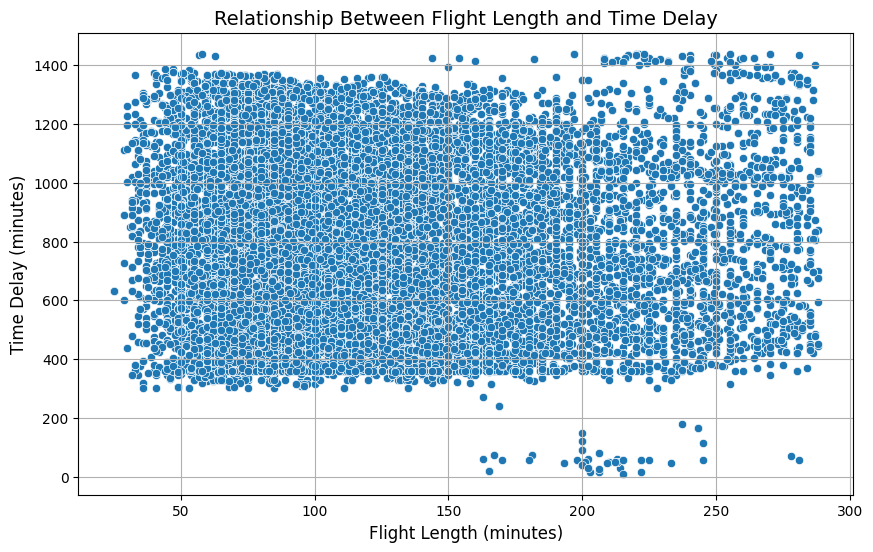

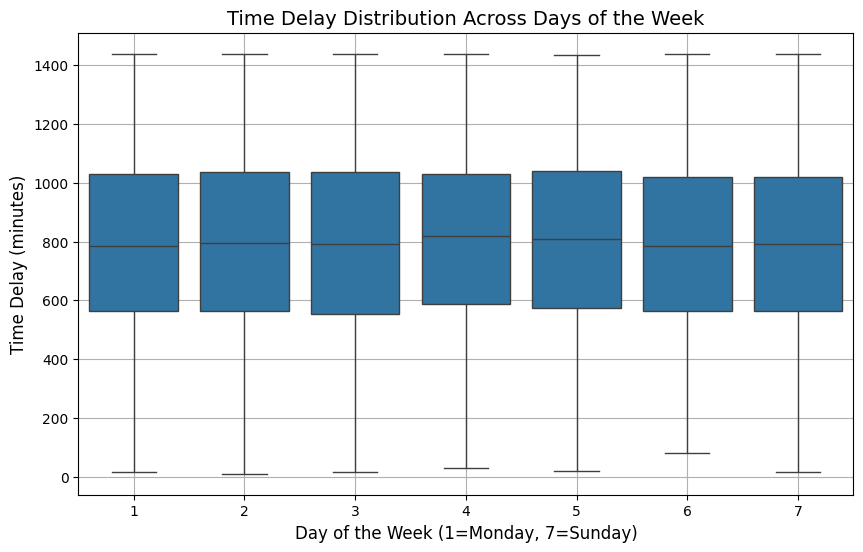

In [625]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_cleaned['Length'], y=data_cleaned['Time_delay'])
plt.title("Relationship Between Flight Length and Time Delay", fontsize=14)
plt.xlabel("Flight Length (minutes)", fontsize=12)
plt.ylabel("Time Delay (minutes)", fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=data_cleaned['DayOfWeek'], y=data_cleaned['Time_delay'])
plt.title("Time Delay Distribution Across Days of the Week", fontsize=14)
plt.xlabel("Day of the Week (1=Monday, 7=Sunday)", fontsize=12)
plt.ylabel("Time Delay (minutes)", fontsize=12)
plt.grid(True)
plt.show()

# Seleksi Atribut (Feature Selection)

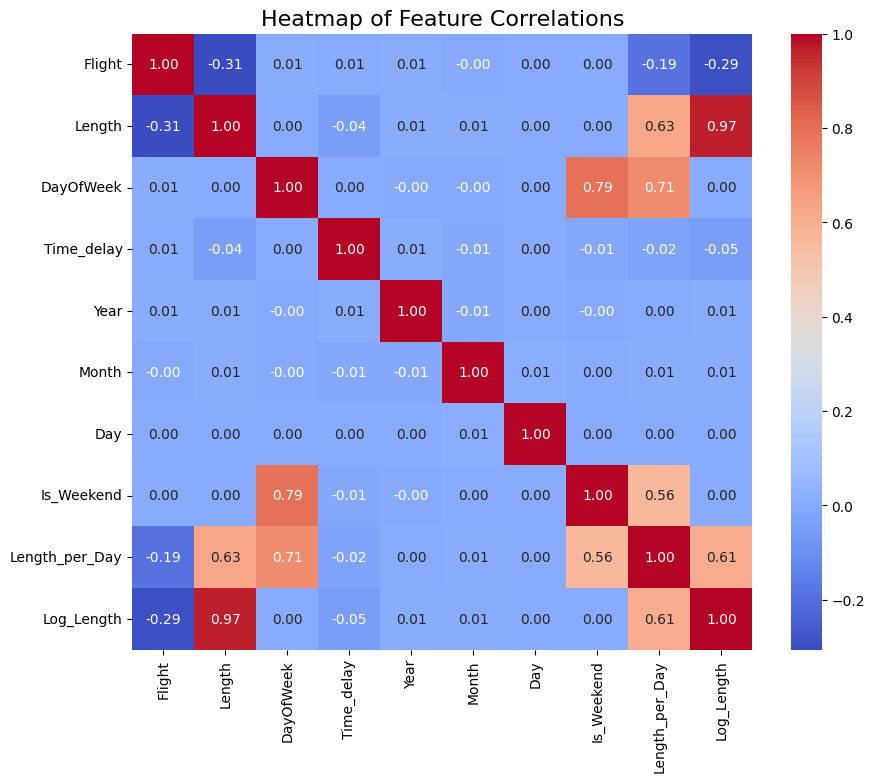

Correlation with the target variable (Time_delay):
Year              0.009178
Flight            0.005156
Day               0.002403
DayOfWeek         0.001003
Month            -0.005339
Is_Weekend       -0.011511
Length_per_Day   -0.023576
Length           -0.042869
Log_Length       -0.048041
Name: Time_delay, dtype: float64

Selected Features for Further Analysis:
['DayOfWeek', 'Length']

Removed Features:
['Flight']

Final Dataset for Further Analysis:
   DayOfWeek  Length  Time_delay
1          3     243         685
2          4      65         590
3          5     105         610
4          6      43         483
5          7     107         940


In [626]:

numeric_data_cleaned = data_cleaned.select_dtypes(include=['number'])

correlation_matrix = numeric_data_cleaned.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Feature Correlations", fontsize=16)
plt.show()

correlation_with_target = correlation_matrix['Time_delay'].drop('Time_delay')
correlation_with_target_sorted = correlation_with_target.sort_values(ascending=False)

print("Correlation with the target variable (Time_delay):")
print(correlation_with_target_sorted)

selected_features = ['DayOfWeek', 'Length']
removed_features = ['Flight']

print("\nSelected Features for Further Analysis:")
print(selected_features)

print("\nRemoved Features:")
print(removed_features)

data_final = data_cleaned[selected_features + ['Time_delay']]

print("\nFinal Dataset for Further Analysis:")
print(data_final.head())

# Prediksi Data menggunakan Linear Regression dengan PySpark

In [627]:
X_train = np.array(train_data_prepared.select("features").rdd.map(lambda row: row.features.toArray()).collect())
y_train = np.array(train_data_prepared.select("Time_delay").rdd.map(lambda row: row.Time_delay).collect())

X_test = np.array(test_data_prepared.select("features").rdd.map(lambda row: row.features.toArray()).collect())
y_test = np.array(test_data_prepared.select("Time_delay").rdd.map(lambda row: row.Time_delay).collect())

xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))

print("XGBoost Mean Absolute Error (MAE):", mae_xgb)
print("XGBoost Root Mean Squared Error (RMSE):", rmse_xgb)

XGBoost Mean Absolute Error (MAE): 234.02069091796875
XGBoost Root Mean Squared Error (RMSE): 274.2128649653404


In [628]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(train_data_prepared)

train_data_normalized = scaler_model.transform(train_data_prepared)
test_data_normalized = scaler_model.transform(test_data_prepared)

In [629]:
lr = LinearRegression(featuresCol="scaled_features", labelCol="Time_delay")
lr_model = lr.fit(train_data_normalized)

In [630]:
predictions = lr_model.transform(test_data_normalized)

In [631]:
spark = SparkSession.builder.appName("AirlinesDelayData").getOrCreate()

data_spark = spark.createDataFrame(data_final)

train_data, test_data = data_spark.randomSplit([0.8, 0.2], seed=42)

print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")

train_data.show(5)

Training Data Count: 20689
Testing Data Count: 5062
+---------+------+----------+
|DayOfWeek|Length|Time_delay|
+---------+------+----------+
|        1|    29|       726|
|        1|    32|       670|
|        1|    33|       364|
|        1|    33|      1140|
|        1|    35|       570|
+---------+------+----------+
only showing top 5 rows



In [632]:
feature_columns = ['DayOfWeek', 'Length']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data_prepared = assembler.transform(train_data)

lr = LinearRegression(featuresCol="features", labelCol="Time_delay")

lr_model = lr.fit(train_data_prepared)

print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

Coefficients: [-0.5731105249527313,-0.2298769453359082]
Intercept: 830.2844930893389


In [633]:
test_data_prepared = assembler.transform(test_data)

predictions = lr_model.transform(test_data_prepared)

evaluator_mae = RegressionEvaluator(labelCol="Time_delay", predictionCol="prediction", metricName="mae")
evaluator_rmse = RegressionEvaluator(labelCol="Time_delay", predictionCol="prediction", metricName="rmse")

mae = evaluator_mae.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 234.29405220095998
Root Mean Squared Error (RMSE): 274.22825345523717


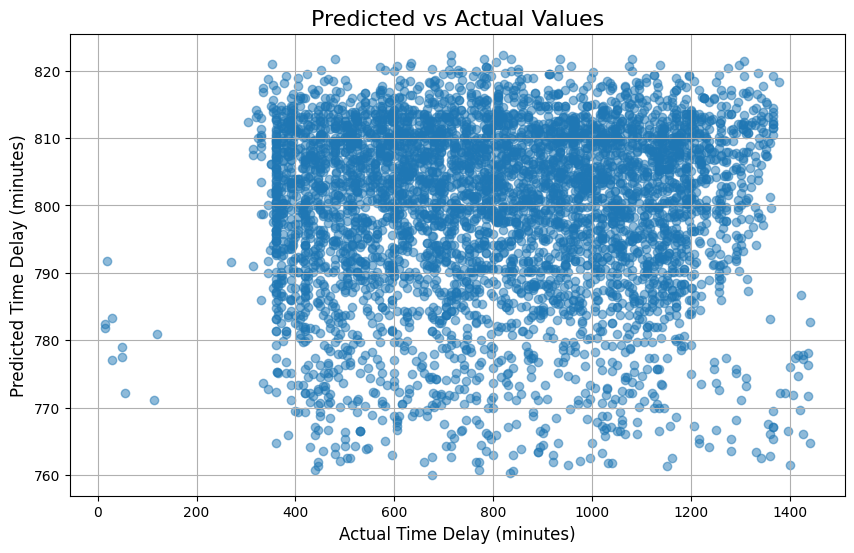

In [634]:
predictions_pandas = predictions.select("prediction", "Time_delay").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas["Time_delay"], predictions_pandas["prediction"], alpha=0.5)
plt.title("Predicted vs Actual Values", fontsize=16)
plt.xlabel("Actual Time Delay (minutes)", fontsize=12)
plt.ylabel("Predicted Time Delay (minutes)", fontsize=12)
plt.grid(True)
plt.show()